<a href="https://colab.research.google.com/github/siwills/NLP_Fake_news/blob/main/NLP__Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!nvidia-smi
!pip install transformers


# Most basic stuff for EDA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, TreebankWordTokenizer, RegexpTokenizer
from nltk.probability import FreqDist
import gensim
import gensim.corpora as corpora
from gensim.utils import tokenize, lemmatize
from gensim.models import CoherenceModel

stop_words = nltk.corpus.stopwords.words('english')

# Loading some sklearn packages for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Loading some tensorflow/keras packages for modeling with LSTM, BiLSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
import tensorflow as tf


# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
#import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime
import itertools  

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Analyse exploratoire des données

Nous allons nous intéresser à la classification de fake news en utilisant le texte de l'article

Le data set est composé de 20 800 articles qui ont été labellisés comme réel ou faux. 

Cette première partie dite d'analyse exporatoire des données est une première étape indispensable à tout problème de data science. En effet, elle nous permet de comprendre et expliquer nos données, de mieux spécifier notre sujet, et d'anticiper les problèmes potentiels auxquels nous pourrions être confrontés. De plus, nous avons décidé de ne pas encore tokenizer et nettoyer les commentaires dans cette partie afin d'exploiter toute l'information présente dans les commentaires incluant le nombre de stopwords, le nombre de mots en majuscule, le nombre de ponctuations ect. Nous exploiterons ces données afin de créer de nouvelles variables si elles semblent pertinentes. Ces nouvelles variables compenseront la perte de donnnées lorsque nous appliquerons notre fonction de nettoyage.

In [ ]:
url="https://raw.githubusercontent.com/sachablair/NLP_Fake_news/main/train.csv "
train= pd.read_csv(url)
train.head()
train.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [ ]:
# Check na values
train.drop(['id', 'author', 'title'],axis=1,inplace=True)
train.isna().sum()

text     39
label     0
dtype: int64

In [ ]:
#remove rows that have blank text and blank title
train_news=train[~(train['text'].isna())]
train_news.isna().sum()

text     0
label    0
dtype: int64

In [ ]:
# keep only the first occurence of the text
train_news.drop_duplicates(subset=['text'],keep='first',inplace=True)
train_news

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1
...,...,...
20795,Rapper T. I. unloaded on black celebrities who...,0
20796,When the Green Bay Packers lost to the Washing...,0
20797,The Macy’s of today grew from the union of sev...,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",1


Afin de mieux comprendre ce que chaque label (réel: 0, ou fake:1) signifie, nous allons afficher un exemple pour chacun :

In [ ]:
#article réel 
print(train_news[train_news['label']==0].iloc[0,0])

Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and Mort

In [ ]:
#article faux
print(train_news[train_news['label']==1].iloc[0,0])

House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) 
With apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. 
As we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emails 

Number of 0 (Reliable) :  10387
Number of 1 (Fake) :  9999


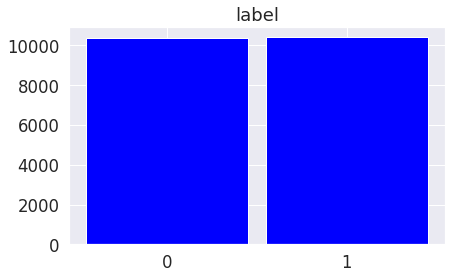

In [ ]:
print('Number of 0 (Reliable) : ', train_news["label"].value_counts()[0])
print('Number of 1 (Fake) : ', train_news["label"].value_counts()[1])

# Class balance analysis
train[['label']].hist(bins = 3)
plt.bar(np.arange(len([0,1])), train.groupby(['label']).size().values, 0.9,  color="blue")
plt.xticks(np.arange(len([0,1])), [0,1])
plt.show()

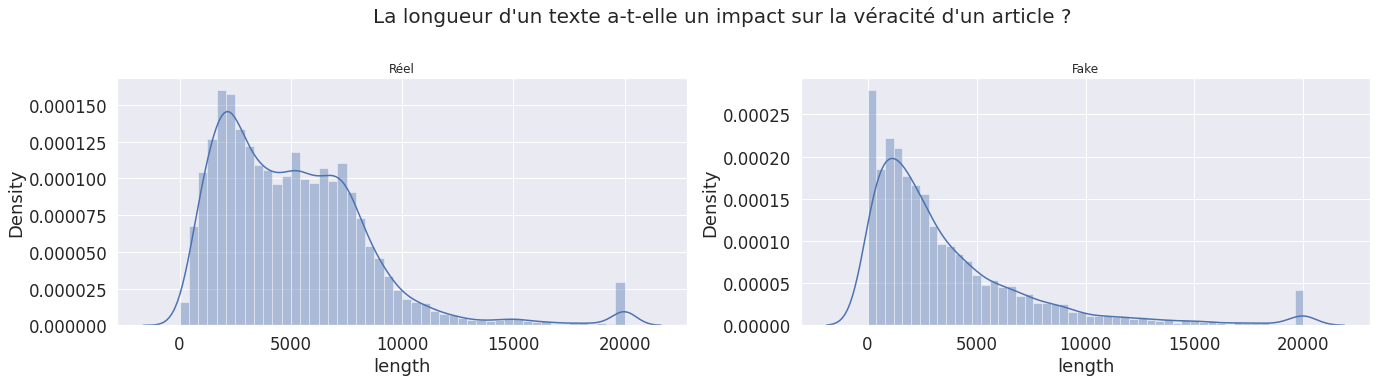

In [ ]:
train_news['length'] = train_news['text'].apply(len)
train_news['length'].loc[train_news['length']>20000] = 20000

plt.figure(figsize=(20,10))
plt.suptitle("La longueur d'un texte a-t-elle un impact sur la véracité d'un article ?", fontsize = 20)
plt.subplot(221)
plt.title('Réel', fontsize = 12)
sns.distplot(train_news[train_news['label'] == 0]['length'])
plt.subplot(222)
plt.title('Fake', fontsize = 12)
sns.distplot(train_news[train_news['label'] == 1]['length'])
plt.show()


Nous observons les articles inventés sont légèrement plus courts que les articles réels.

In [ ]:
train_news['count_stopwords'] = train_news["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words])) # on compte le nombre de stopwords dans un commentaire
train_news['count_unique_word'] = train_news["text"].apply(lambda x: len(set(str(x).split()))) # on compte le nombre de mots uniques dans un commentaire
train_news['count_stopwords'].loc[train_news['count_stopwords']>1000] = 1000
train_news['count_unique_word'].loc[train_news['count_unique_word']>1000] = 1000

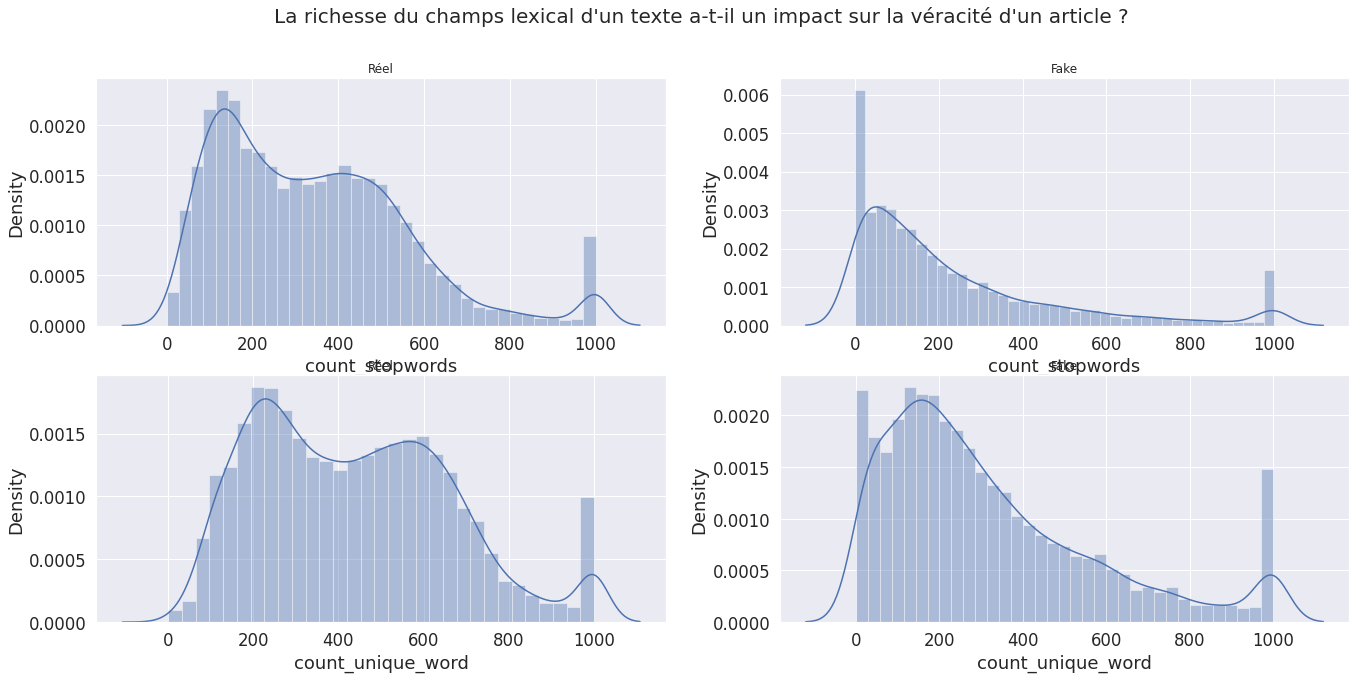

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle("La richesse du champs lexical d'un texte a-t-il un impact sur la véracité d'un article ?", fontsize = 20)
plt.subplot(221)
plt.title('Réel', fontsize = 12)
sns.distplot(train_news[train_news['label'] == 0]['count_stopwords'])
plt.subplot(222)
plt.title('Fake', fontsize = 12)
sns.distplot(train_news[train_news['label'] == 1]['count_stopwords'])
plt.subplot(223)
plt.title('Réel', fontsize = 12)
sns.distplot(train_news[train_news['label'] == 0]['count_unique_word'])
plt.subplot(224)
plt.title('Fake', fontsize = 12)
sns.distplot(train_news[train_news['label'] == 1]['count_unique_word'])
plt.show()

On constate que la richesse du champs lexical employé dans les textes réels et inventés est légèrement différentes.

En effet, en ce qui concerne le nombre de stopwords employés, généralement utilisés dans les phrases bien construites, est plus important dans les articles réels.

De plus, les articles inventés ont tendance moins de mots uniques et donc avoir un vocabulaire/lexique moins large.

Nous ne retiendrons pas les variables étudiées (longueur de l'article, variété du vocabulaire ou nombre de stop words) pour la suite de l'étude, les différences ne sont pas majeures à l'exception du nombre de stop words qui pourrait être utilisé dans la classification.

Cette seconde partie est consacrée à la tokenization et au cleaning des articles afin d'épurer ceux-ci et d'en retirer les informations les plus pertinentes. Dans la partie cleaning, nous décidons de mettre en miniscules les artciles, de retirer : liens HTML/liens/emails/stopwords/brackets/caractères spéciaux, et enfin de lemmatiser.

In [ ]:
#Dataset preprocessing
charmap = { 0x201c : u'"',
            0x201d : u'"',
            0x2018 : u"'",
            0x2019 : u"'" }

tokenizer= TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text=text.translate(charmap)
    text = text.lower()
    text=text.replace('{html}',"") 
    text=text.replace('#',"")
    text=re.sub("[\"\']", "",text)# quotes and double quotes
    text=re.sub('https?://[A-Za-z0-9./]+','',text)#links
    tag = re.compile('<.*?>') # balises
    text = re.sub(tag, '', text)
    mail = re.compile('\S*@\S*\s?') #email
    text=re.sub(mail, '',text)
    text=re.sub(r'\[(.*?)\]',' ',text)# brackets
    tokens = tokenizer.tokenize(text)  
    processed_tokens = [w for w in tokens  if not w in stop_words]
    processed_tokens=[lemmatizer.lemmatize(w) for w in processed_tokens]
    return " ".join(processed_tokens)

train_news['cleanText']=train_news['text'].map(lambda x:preprocess(x))

Analysons un article afin d'observer le nettoyage effectué.

In [ ]:
train_news['cleanText'][5]

'trying time , jackie mason voice reason. could win left , theyll fall love minute. bombed better reason , jackie explains. like transgender toilets. jackie also say surprise hollywood celebrity didnt support trump strike syrian airfield month. infuriated , says. might save lives. doesnt mean anything them. saved environment , climate change ! theyd happiest people world. still , jackie say he got nothing hollywood celebs. theyve got tough life country. watch jackies latest clip above. follow daniel nussbaum twitter :'

Analyse des mots souvent utilisés dans les articles inventés

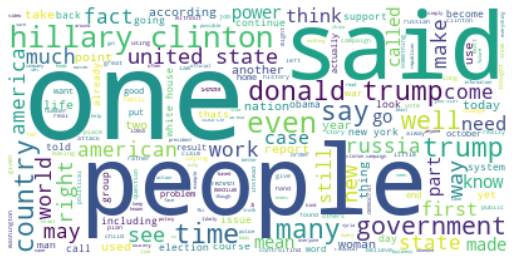

In [ ]:
# Wordcloud for fake
text = " ".join([x for x in train_news.cleanText[train_news.label==1]])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

Analyse des mots souvent utilisés dans les véritables articles

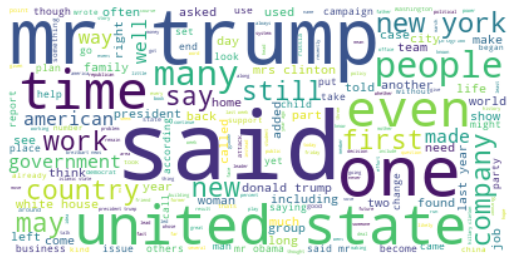

In [ ]:
# Wordcloud for real
text = " ".join([x for x in train_news.cleanText[train_news.label==0]])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

Il est assez difficile de voir la différence de vocabulaire entre de vrais articles et des articles inventés.

**LDA** 

Analysons un peu plus en détail les articles en utilisant le LDA

In [ ]:

# Build the bigram and trigram models

bigram = gensim.models.Phrases(train_news['cleanText'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[train_news['cleanText']], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# tokenizer de gensim (environ 38 min)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def process_words(texts):
    texts = list(sent_to_words(texts))
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en')
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if len(token)>2])
    return texts_out

data_ready = process_words(train_news['cleanText'])  # processed Text Data!

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10)

print(lda_model.print_topics())

[(0, '0.025*"say" + 0.007*"police" + 0.005*"year" + 0.005*"state" + 0.005*"one" + 0.005*"people" + 0.004*"officer" + 0.004*"city" + 0.004*"new" + 0.004*"man"'), (1, '0.007*"-PRON-" + 0.006*"like" + 0.006*"one" + 0.006*"say" + 0.006*"people" + 0.005*"know" + 0.005*"time" + 0.005*"make" + 0.004*"get" + 0.004*"book"'), (2, '0.008*"say" + 0.007*"one" + 0.006*"like" + 0.005*"make" + 0.005*"time" + 0.005*"-PRON-" + 0.004*"get" + 0.004*"year" + 0.004*"take" + 0.004*"people"'), (3, '0.017*"clinton" + 0.009*"say" + 0.009*"hillary" + 0.007*"email" + 0.006*"state" + 0.006*"fbi" + 0.005*"would" + 0.005*"election" + 0.005*"investigation" + 0.005*"campaign"'), (4, '0.012*"say" + 0.006*"country" + 0.006*"israel" + 0.005*"european" + 0.005*"state" + 0.005*"world" + 0.005*"year" + 0.004*"people" + 0.004*"one" + 0.004*"would"'), (5, '0.011*"war" + 0.008*"russia" + 0.008*"state" + 0.008*"syria" + 0.007*"military" + 0.007*"say" + 0.006*"government" + 0.006*"force" + 0.005*"russian" + 0.005*"attack"'), (6,

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

lda_display = gensimvis.prepare(lda_model, corpus, id2word)
lda_display


PreparedData(topic_coordinates=           x      y  topics  cluster    Freq
topic                                       
9     -0.094 -0.024       1        1  15.414
2     -0.070 -0.082       2        1  15.362
6     -0.055 -0.021       3        1  14.065
0     -0.056 -0.044       4        1  13.557
3     -0.080 -0.011       5        1  11.375
1     -0.062 -0.088       6        1  10.602
5     -0.040  0.091       7        1   9.743
4     -0.044  0.041       8        1   6.690
8      0.119  0.244       9        1   1.731
7      0.383 -0.108      10        1   1.462, topic_info=            Term       Freq      Total Category  logprob  loglift
464        trump  55861.000  55861.000  Default   30.000   30.000
40       clinton  27072.000  27072.000  Default   29.000   29.000
815          war  12351.000  12351.000  Default   28.000   28.000
192   republican  12561.000  12561.000  Default   27.000   27.000
1726      russia   9527.000   9527.000  Default   26.000   26.000
...          ...        ...        ...      ...      ...      ...
2851         von    287.273    419.773  Topic10   -6.055    3.846
855          die    924.557   4440.513  Topic10   -4.886    2.656
1561     company    303.175  11742.806  Topic10   -6.001    0.569
200          say    332.336  97975.458  Topic10   -5.909   -1.461
7480     airline    168.098    621.483  Topic10   -6.591    2.918

[949 rows x 6 columns], token_table=       Topic   Freq    Term
term                       
0          1  0.197  -PRON-
0          2  0.245  -PRON-
0          3  0.071  -PRON-
0          4  0.086  -PRON-
0          5  0.080  -PRON-
...      ...    ...     ...
6301      10  0.997     что
22060     10  0.994   чтобы
14130      7  0.001     это
14130     10  0.998     это
14132     10  0.991    этом

[4470 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 7, 1, 4, 2, 6, 5, 9, 8])

### Classication des fakes news

Dans cette partie, nous allons essayer de classifier correctement les articles en réel ou faux. La première approche utilise TF-IDF + les algorithmes de machine learning de classification (régression logistique, naîve Bayes, SVM, RF).

 **First part: Machine learning approaches**

**1 TF-IDF**

In [ ]:
# Tfidf
tfidf = TfidfVectorizer()
features = tfidf.fit_transform(train_news['cleanText'])
label=train_news['label']
X_train,X_test,y_train,y_test=train_test_split(features,label,test_size=0.2) 


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**1-1 Logistic Regression**

Accuracy is:  0.9507111329082883
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2056
           1       0.95      0.96      0.95      2022

    accuracy                           0.95      4078
   macro avg       0.95      0.95      0.95      4078
weighted avg       0.95      0.95      0.95      4078

Confusion matrix, without normalization


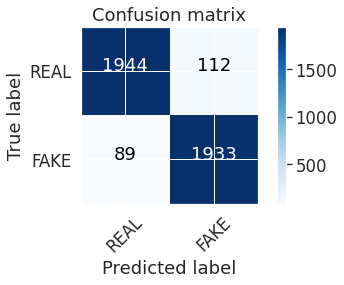

In [ ]:
# logistic regression
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred_lr=lr.predict(X_test)
print ("Accuracy is: ", metrics.accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
lr_cm = metrics.confusion_matrix(y_test, y_pred_lr)
lr_cm
plot_confusion_matrix(lr_cm, classes=['REAL','FAKE'])

**1-2 Naive Bayes**

Accuracy is:  0.8415890142226582
              precision    recall  f1-score   support

           0       0.77      0.99      0.86      2059
           1       0.98      0.69      0.81      2019

    accuracy                           0.84      4078
   macro avg       0.87      0.84      0.84      4078
weighted avg       0.87      0.84      0.84      4078

Confusion matrix, without normalization


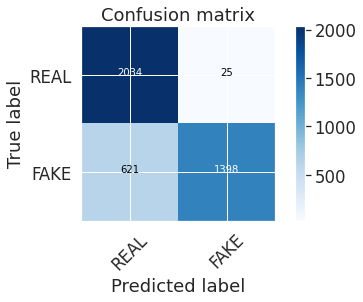

In [ ]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train,y_train)
y_pred_nb=nb.predict(X_test)
print ("Accuracy is: ", metrics.accuracy_score(y_test, y_pred_nb))
nb_cm = metrics.confusion_matrix(y_test, y_pred_nb)
print(classification_report(y_test, y_pred_nb))
plot_confusion_matrix(nb_cm, classes=['REAL','FAKE'])

**1-3 SVM**

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2059
           1       0.96      0.97      0.96      2019

    accuracy                           0.96      4078
   macro avg       0.96      0.96      0.96      4078
weighted avg       0.96      0.96      0.96      4078

Confusion matrix, without normalization


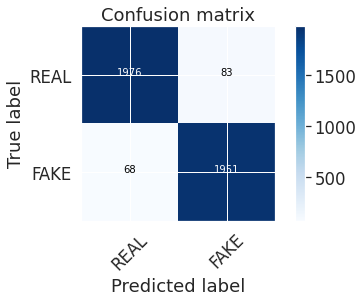

In [ ]:
# SVM
svc = SVC(kernel='linear', random_state=1) 
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))
svc_cm = metrics.confusion_matrix(y_test, y_pred_svc)
plot_confusion_matrix(svc_cm, classes=['REAL','FAKE'])

**1-4 Random Forest**

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2059
           1       0.94      0.90      0.92      2019

    accuracy                           0.92      4078
   macro avg       0.92      0.92      0.92      4078
weighted avg       0.92      0.92      0.92      4078

Confusion matrix, without normalization


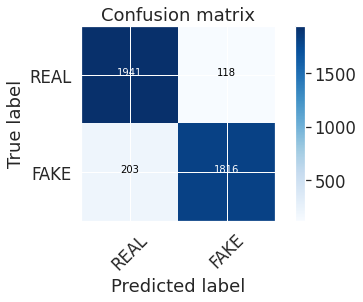

In [ ]:
# RF

rf = RandomForestClassifier(random_state = 1)

param_grid = {
    'n_estimators': [100],
    'max_depth': [30, 40, 50]
    }

grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5)
grid_search_rf.fit(X_train, y_train)
grid_search_rf.best_params_
y_pred_rf = grid_search_rf.predict(X_test)
rf_cm = metrics.confusion_matrix(y_test, y_pred_rf)
print(classification_report(y_test, y_pred_rf))
plot_confusion_matrix(rf_cm, classes=['REAL','FAKE'])

Quoique simple,l'approche TF -IDF combinée avec les méthodes classiques de machine learning permet de générer d'assez bon résultats avec des accuracy qui vont de 0.85 jusqu'à 0.94 et une meilleur performance assurée par l'algorithme Support Vector Machine.


La seconde approche utilise des embeddings plus complet pour les mots que TF-IDF. En effet, nous utilisons Word2Vec comme embedding de chaque mot. Nous combinerons ces embeddings avec des réseaux de neurones récurrents (LSTM et BiLSTM) afin de déterminer si l'article est réel ou inventé.

**Second part: Word Embeddings and Reccurrent neural Network**

**2-1 Word2vec + LSTM**

In [ ]:

#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=data_ready, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 154905 words by a 100dim vector.

158272

Keras dispose d'une implémentation "Embedding Layer" pour la création de vecteurs d'embedding. Mais comme on a déjà utilisé Word2vec de gensim, on va directement charger ces vecteurs dans la couche d'embedding et ne pas entrainer cette couche. Chaque mot doit être passé à la couche d'embedding sous forme d'un mot au lieu d'une chaîne de caractère et c'est la raison pour laquelle on utilise le Tokenizer.

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_ready)

X = tokenizer.texts_to_sequences(data_ready)

In [ ]:
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index

On utilise un input de taille fixe pour le Many-To-One model de RNN.

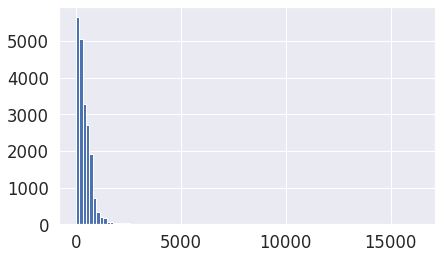

There are 411 words after preprocessing in average
There is 94.9 % of news with less than 1000 words after preprocessing


In [ ]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 1000 words.
# Lets keep each news small and truncate all news to 1000 while tokenizing
plt.hist([len(x) for x in X], bins=100)
plt.show()

size_news = np.array([len(x) for x in X])

print("There are {} words after preprocessing in average".format(round(np.mean(size_news))))
len_news = 1000
print("There is {} % of news with less than {} words after preprocessing".format(round(len(size_news[size_news  < len_news])/len(X) * 100, 1), len_news))

# Its heavily skewed. There are news with 5000 words. Let's truncate these outliers

On garde les articles dont la longueur est inférieur à 1000 mots et on pad pour ceux qui sont en dessus de cette limite et on tronque pour ceux qui dépassent. 

In [ ]:
#Let's keep all news to 1000, add padding to news with less than 1000 words and truncating long ones
maxlen = 1000 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        #weight_matrix[i] = model[word]
        try: weight_matrix[i] = model[word]
        except: weight_matrix[i] = np.zeros(100)
    return weight_matrix

On crée une matrice de Mapping entre word-index et les vecteurs et on l'utilise comme poins pour la couche d'embedding. 
La longueur de l'input vecteur pour la couche d'embedding est de 1000 (taille de chaque article)


In [ ]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, train_news.label) 

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
335/335 [==============================] - 51s 54ms/step - loss: 0.4152 - acc: 0.8078 - val_loss: 0.2592 - val_acc: 0.8947
Epoch 2/6
335/335 [==============================] - 17s 52ms/step - loss: 0.2527 - acc: 0.9007 - val_loss: 0.2792 - val_acc: 0.8873
Epoch 3/6
335/335 [==============================] - 18s 53ms/step - loss: 0.2154 - acc: 0.9159 - val_loss: 0.2044 - val_acc: 0.9180
Epoch 4/6
335/335 [==============================] - 18s 54ms/step - loss: 0.1544 - acc: 0.9400 - val_loss: 0.2215 - val_acc: 0.9248
Epoch 5/6
335/335 [==============================] - 18s 53ms/step - loss: 0.1655 - acc: 0.9379 - val_loss: 0.1627 - val_acc: 0.9355
Epoch 6/6
335/335 [==============================] - 18s 53ms/step - loss: 0.1089 - acc: 0.9591 - val_loss: 0.1473 - val_acc: 0.9424


In [ ]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2601
           1       0.97      0.93      0.95      2496

    accuracy                           0.95      5097
   macro avg       0.95      0.95      0.95      5097
weighted avg       0.95      0.95      0.95      5097

Confusion matrix, without normalization


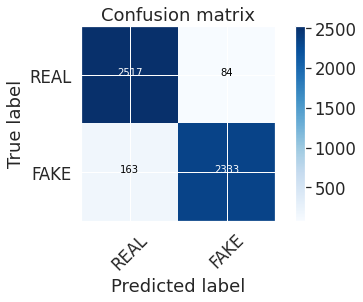

In [ ]:
#print(classification_report(y_test, y_pred))

ltsm_cm = metrics.confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(ltsm_cm, classes=['REAL','FAKE'])

**2-2 Word2vec + BILSTM**

In [ ]:
# Building an LSTM Model with an embedding layer #
model1 = Sequential()
model1.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model1.add(Bidirectional(LSTM(128)))  # 128 memory cells / Neurons 
model1.add(Dense(1,activation='sigmoid'))  # sigmoid will help in classifying news as fake or real
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         15827300  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,062,053
Trainable params: 234,753
Non-trainable params: 15,827,300
_________________________________________________________________
None


In [ ]:
# training model
model1.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
335/335 [==============================] - 36s 100ms/step - loss: 0.4165 - accuracy: 0.8017 - val_loss: 0.2731 - val_accuracy: 0.8886
Epoch 2/6
335/335 [==============================] - 33s 99ms/step - loss: 0.2767 - accuracy: 0.8874 - val_loss: 0.2777 - val_accuracy: 0.8803
Epoch 3/6
335/335 [==============================] - 33s 99ms/step - loss: 0.2033 - accuracy: 0.9203 - val_loss: 0.2106 - val_accuracy: 0.9220
Epoch 4/6
335/335 [==============================] - 33s 99ms/step - loss: 0.1584 - accuracy: 0.9420 - val_loss: 0.2096 - val_accuracy: 0.9185
Epoch 5/6
335/335 [==============================] - 33s 99ms/step - loss: 0.1217 - accuracy: 0.9526 - val_loss: 0.1720 - val_accuracy: 0.9357
Epoch 6/6
335/335 [==============================] - 34s 100ms/step - loss: 0.1041 - accuracy: 0.9626 - val_loss: 0.1529 - val_accuracy: 0.9486


              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2601
           1       0.96      0.95      0.95      2496

    accuracy                           0.95      5097
   macro avg       0.95      0.95      0.95      5097
weighted avg       0.95      0.95      0.95      5097

Confusion matrix, without normalization


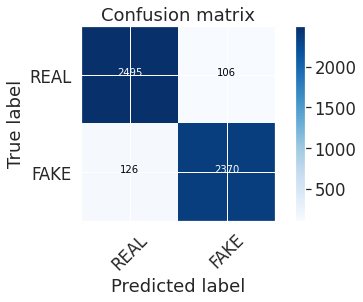

In [ ]:
y_pred = (model1.predict(X_test) >= 0.5).astype("int")
biltsm_cm = metrics.confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(biltsm_cm, classes=['REAL','FAKE'])

La troisième approche BERT

In [ ]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.  
    
    device = torch.device('cuda')    


    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
labels = train_news['label'].values
combined = train_news['text'].values

In [ ]:
combined

array(['House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewi

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [ ]:
print(' Original: ', combined[0])


print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the sentence mapped to token ID's.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

 Original:  House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) 
With apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. 
As we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was revie

In [ ]:
train, test, y_train, y_test = train_test_split(combined, labels, test_size=0.2, random_state=42)

In [ ]:
def tokenize_map(sentence,labels='None'):  
    """A function for tokenize all of the sentences and map the tokens to their word IDs."""
    
    #global labels
    
    input_ids = []
    attention_masks = []

    # For every sentence...
    
    for text in sentence:
        #   "encode_plus" will:
        
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 128,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list. 
        
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labels != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [ ]:
input_ids, attention_masks, train_labels = tokenize_map(train, y_train) #5min30
test_input_ids, test_attention_masks= tokenize_map(test)#1min30

In [ ]:
# Combine the training inputs into a TensorDataset.

dataset = TensorDataset(input_ids, attention_masks, train_labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

13,046 training samples
3,262 validation samples


In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it here. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 4

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [ ]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the device which we set GPU in our case.

model.to(device)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [ ]:
# Get all of the model's parameters as a list of tuples:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch).

optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [ ]:
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    
    """A function for calculating accuracy scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    
    """A function for calculating f1 scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, pred_flat)

In [ ]:
def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# we kept only to epchs to reduce teh execution time
# We'll store a number of quantities such as training and validation loss, validation accuracy, f1 score and timings.

training_stats = []

# Measure the total training time for the whole run.

total_t0 = time.time()

# For each epoch...

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes:
    
    t0 = time.time()

    # Reset the total loss for this epoch.
    
    total_train_loss = 0

    # Put the model into training mode.
    
    model.train()

    # For each batch of training data...
    
    for step, batch in enumerate(train_dataloader):

        # Progress update every 10 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device(gpu in our case) using to the methode
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)
        
        model.zero_grad()        
        
        # It returns different numbers of parameters depending on what arguments given and what flags are set. For our useage here, it returns the loss (because we provided labels),
        # And the 'logits' (the model outputs prior to activation.)
        loss = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[0]
        logits = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[1]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end, 
        # `loss` is a tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        
        loss.backward()

        # Clip the norm of the gradients to 1.0 This is to help prevent the 'exploding gradients' problem.
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        
        # The optimizer dictates the 'update rule'(How the parameters are modified based on their gradients, the learning rate, etc.)
        
        optimizer.step()

        # Update the learning rate.
        
        scheduler.step()

    # Calculate the average loss over all of the batches.
    
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    
    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print('')
    print('Running Validation...')

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    
    model.eval()

    # Tracking variables:
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch.
    
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            
            loss = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[0]

            logits = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[1]
            
        # Accumulate the validation loss.
        
        total_eval_loss += loss.item()

        # Move logits and labels to CPU:
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all bat
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
    
    # Report the final f1 score for this validation run.
    
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    # Calculate the average loss over all of the batches.
    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    
    
    # Measure how long the validation run took:
    
    validation_time = format_time(time.time() - t0)
    
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    # Record all statistics from this epoch.
    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    50  of  3,262.    Elapsed: 0:00:25.
  Batch   100  of  3,262.    Elapsed: 0:00:51.
  Batch   150  of  3,262.    Elapsed: 0:01:16.
  Batch   200  of  3,262.    Elapsed: 0:01:42.
  Batch   250  of  3,262.    Elapsed: 0:02:09.
  Batch   300  of  3,262.    Elapsed: 0:02:35.
  Batch   350  of  3,262.    Elapsed: 0:03:02.
  Batch   400  of  3,262.    Elapsed: 0:03:28.
  Batch   450  of  3,262.    Elapsed: 0:03:55.
  Batch   500  of  3,262.    Elapsed: 0:04:21.
  Batch   550  of  3,262.    Elapsed: 0:04:48.
  Batch   600  of  3,262.    Elapsed: 0:05:15.
  Batch   650  of  3,262.    Elapsed: 0:05:42.
  Batch   700  of  3,262.    Elapsed: 0:06:09.
  Batch   750  of  3,262.    Elapsed: 0:06:36.
  Batch   800  of  3,262.    Elapsed: 0:07:02.
  Batch   850  of  3,262.    Elapsed: 0:07:29.
  Batch   900  of  3,262.    Elapsed: 0:07:56.
  Batch   950  of  3,262.    Elapsed: 0:08:23.
  Batch 1,000  of  3,262.    Elapsed: 0:08:49.
  Batch 1,050  of

In [ ]:
# Display floats with two decimal places.

pd.set_option('precision', 3)

# Create a DataFrame from our training statistics.

df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.

df_stats = df_stats.set_index('epoch')

# Display the table.

display(df_stats)

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,0.154,0.078,0.983,0.918,0:28:58,0:02:51
2,0.035,0.089,0.985,0.919,0:28:59,0:02:53


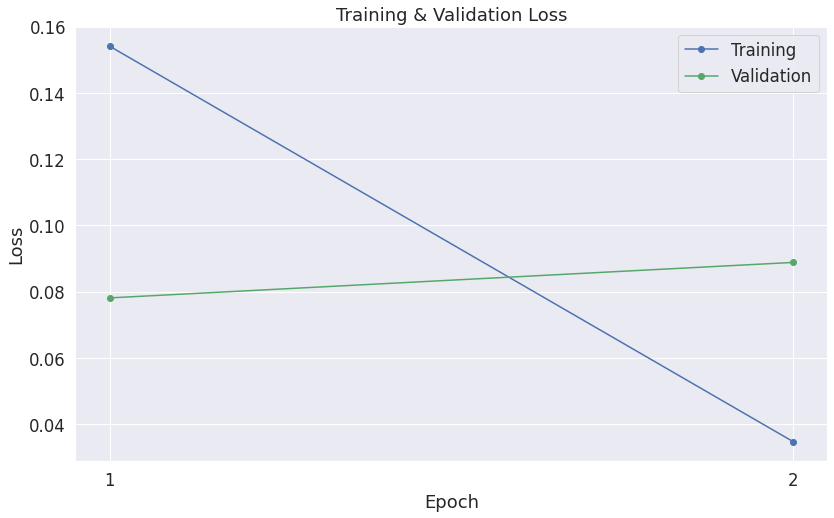

In [ ]:
# Increase the plot size and font size:

fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label the plot:

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.xticks([1, 2])

plt.show()

In [ ]:

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode:

model.eval()

# Tracking variables :

predictions = []

# Predict:

for batch in prediction_dataloader:
    
  # Add batch to GPU

  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader:
    
  b_input_ids, b_input_mask, = batch
  
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction:

  with torch.no_grad():
      # Forward pass, calculate logit predictions:
    
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU:
    
  logits = logits.detach().cpu().numpy()
 
    
    
  
  # Store predictions and true labels:
    
  predictions.append(logits)


print('    DONE.')

Predicting labels for 4,078 test sentences...
    DONE.


In [ ]:
# Getting list of predictions and then choosing the target value with using argmax on probabilities.

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
flat_predictions

array([1, 1, 0, ..., 0, 0, 1])

Accuracy is:  0.9872486512996567
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2056
           1       1.00      0.98      0.99      2022

    accuracy                           0.99      4078
   macro avg       0.99      0.99      0.99      4078
weighted avg       0.99      0.99      0.99      4078

Confusion matrix, without normalization


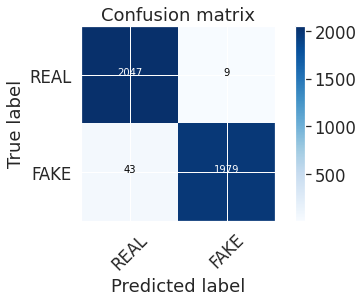

In [ ]:
print ("Accuracy is: ", metrics.accuracy_score(y_test, flat_predictions))
bert_cm = metrics.confusion_matrix(y_test, flat_predictions)
print(classification_report(y_test, flat_predictions))
plot_confusion_matrix(bert_cm, classes=['REAL', 'FAKE'])